
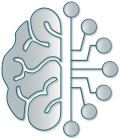

**Start at:** Monday 27 May 2024, 17:09:04  
**Hostname:** insa-12842 (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/pyPhysChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

In [1]:
import os
import sys

cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color, fg, bg, hl
vID.init(cwd0)
import tools4pyPhysChem as t4pPC

#cancel the "last show-up" behaviour of Jupyter notebooks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Autoencoders

## Introduction

<div class="intro">

A classic result in cognitive psychology is that experts have an excellent memory for meaningful material taken from their domain of expertise, **even when this material is presented only briefly**. 
As proposed by Herbert A. Simon and William G. Chase in their 1973 paper titled "Perception in Chess", expertise in chess is acquired by learning, through practice and study, a large number of "**chunks**", which are units of both perception and meaning. Chunks consist of constellations of pieces occurring often together in masters’ games. Experts’ superiority with meaningful material (game positions in chess) is explained by their ability to **rapidly memorize positions on a chess game** by **identifying patterns present on the board**, and retrieve chunks from their long-term memory (LTM).

<img width="40%" src="./ML-Figures/Chess/Chess.svg" style="display:block; margin-left:auto; margin-right:auto" id="Fischer"/> 
<br>

The connection between Chase and Simon's work on **chunking in chess** and **autoencoders** lies in the concept of learning **meaningful (*compact*) representations**. In both cases, the goal is to extract and represent important features or patterns from complex data.

In the context of chess, the process of chunking involves recognizing meaningful patterns or configurations of pieces on the board. Similarly, **an autoencoder learns to extract the most important features from the input data** (in this case, a lower-dimensional representation) **that are sufficient to reconstruct the original input**. This process can be thought of as finding an efficient **compact representation**, the **latent representation**, that captures the essential information in the data.

</div>
<br>
<div class="intro">

An autoencoder is a type of artificial neural network used for **unsupervised learning**. It is designed to learn efficient representations or codings of input data, typically for the purpose of dimensionality reduction, feature extraction, or generative modeling. 

Autoencoder, by design, reduces data dimensions by learning how to ignore the noise in the data.
    
<img width="30%" src="./DS4B-Slides/pngs/ZooNN/AEwithLegend.svg" style="display:block; margin-left:auto; margin-right:auto" id="AE"/> 

Autoencoders consists of three main parts:

1- **Encoder**: In which the model learns how to reduce the input dimensions and compress the input data into an encoded representation.

2- **Bottleneck** or **Latent space**: which is the layer that contains the compressed representation of the input data. This is the lowest possible dimensions of the input data.

3- **Decoder**: In which the model learns how to reconstruct the data from the encoded representation to be as close to the original input as possible.

Another important component is the **Reconstruction Loss**: this is the method that measures how well the decoder is performing and how close the output is to the original input

When we use autoencoders, we actually do not care about the output itself, but rather we care about the vector constructed in the middle (the **latent vector**). This vector is important because it is a representation of the input image and with this representation, we could potentially do several tasks like reconstructing the original image. We can think of the latent vector as a code for an image, which is where the terms encode/decode come from. 


</div>

## Application to the Fashion MNIST dataset

In [2]:
import sklearn
import tensorflow as tf
import keras
import numpy as np

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

tf.config.experimental.list_physical_devices()
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")

2024-05-27 17:09:07.474339: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 17:09:07.475011: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 17:09:07.505114: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 17:09:07.620508: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 17:09:08.461123: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

No GPU was detected. Neural nets can be very slow without a GPU.


### Useful functions

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "ML-SavedFigures"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

MODELS_PATH = Path() / "ML-Savedmodels"
MODELS_PATH.mkdir(parents=True, exist_ok=True)

def get_var_name(arg):
    return [k for k,v in globals().items() if v == arg]

def save_fig(fig_id, IMAGES_PATH=".", tight_layout=True, fig_extension="png", resolution=300):
    '''
    saves a figure to a given subfolder, that will be created if it does not exist
    input:
        - fig_id = name of the figure, without an extension
        - IMAGES_PATH = pathway to the folder. Default: "."
        - tight_layout = boolean. Automatically adjusts subplot params so that the subplot(s) fits in to the figure area. Default: True
        - fig_extension = image type. Default: png
        - resolution = resolution of the figure, in dpi. Default: 300
    '''
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return

def saveModel(model, model_id, MODELS_PATH=".", model_extension="keras"):
    '''
    saves a model to a given subfolder, that will be created if it does not exist
    input:
        - model = keras model
        - model_id = name of the model file, without an extension
        - MODELS_PATH = pathway to the folder. Default: "."
        - model_extension = model type. Default: keras
    '''
    path = MODELS_PATH / f"{model_id}.{model_extension}"
    model.save(path)
    return

def plotModel(model, model_id, MODELS_PATH=".", fig_extension="png", resolution=300,
              show_shapes=True, show_layer_names=True, show_layer_activations=True):
    '''
    saves a model plot to a given subfolder, that will be created if it does not exist
    input:
        - model = keras model
        - model_id = name of the model file, without an extension
        - MODELS_PATH = pathway to the folder. Default: "."
        - model_extension = model type. Default: png
    '''
    from tensorflow.keras.utils import plot_model
    from matplotlib.pyplot import plot
    path = MODELS_PATH / f"{model_id}.{fig_extension}"
    plot_model(model, to_file=path, dpi=resolution, show_shapes=show_shapes, 
               show_layer_names=show_layer_names, show_layer_activations=show_layer_activations)
    img = plt.imread(path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return

def plotFashionToGrid(X, y, fashion_names, nrows=5, ncols=8, startFrom=0, yActual=None, saveFig = False, IMAGES_PATH=".",save_imgs=False, fig_extension="png"):
    '''
    plots nrows x ncols images with plt.imshow(), with their label as title
    input:
        - X = array with nimg b&w images coded as (npix,npix). Size = (nimg, npix, npix)  
        - y = 1D array made of nimg integers = class number
        - fashion_names = array with the corresponding class names
        - nrows, ncols = dimension of the plot grid (nrows x ncols must be <= nimg)
        - startFrom = index of the first image that will be shown
        - yActual = only useful when evaluating a prediction. It will contain the
          actual integer labels of the images
          In this case, y must be set to the value predicted by the model
          When a prediction is wrong, the label will be shown in red
        - saveFig = saves the figure to IMAGES_PATH
        - IMAGES_PATH = pathway to save images. Default: "."
    '''
    from matplotlib import pyplot as plt
    from PIL import Image

    plt.rc('font', size=14)
    plt.rc('axes', labelsize=14, titlesize=12)
    plt.rc('legend', fontsize=14)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.figure(figsize=(ncols * 1.2, nrows * 1.2))
    nimg = nrows * ncols
    if nimg > len(y) - startFrom:
        print(f"Sample size = {len(y)}. Cannot plot {nrows} x {ncols} = {nimg} images, with startFrom set as {startFrom}")
        print(f"startFrom automatically setup to {len(y) - nimg}")
        startFrom = len(y) - nimg
    for row in range(nrows):
        for col in range(ncols):
            index = ncols * row + col + startFrom
            plt.subplot(nrows, ncols, index + 1 - startFrom) # the third argument represents the index of the subplot that will be used
            plt.imshow(X[index], cmap="binary", interpolation="nearest",vmin=0.0, vmax=1.0) # the data X is resampled to the pixel size of the image on the figure canvas, using the "nearest" interpolation method
            plt.axis('off')
            colorTitle = 'black'
            if yActual is not None and yActual[index] != y[index]:
                colorTitle='red'
            plt.title(fashion_names[y[index]],color=colorTitle)
            if save_imgs:
                file = IMAGES_PATH + f"img{index:06d}.{fig_extension}" 
                I8 = (((X[index] - X[index].min()) / (X[index].max() - X[index].min())) * 255.9).astype(np.uint8)
                img = Image.fromarray(I8)
                img.save(file)

    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    if (saveFig):
        save_fig(IMAGES_PATH,"fashion_mnist_grid",fig_extension=fig_extension)
    plt.show()
    return

def compareReconstructionsWithOriginalImages(model, imgDataset, nimg=5, startFrom=0, saveFig = False, IMAGES_PATH="."):

    selectedImg = imgDataset[startFrom:startFrom+nimg]
    reconstrucedImg = model.predict(selectedImg)
    
    plt.rc('font', size=14)
    plt.rc('axes', labelsize=14, titlesize=12)
    plt.rc('legend', fontsize=14)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.figure(figsize=(nimg*1.5, 2*1.5)) #1 row for actual images, 1 row for reconstructed images
    if nimg > imgDataset.shape[0] - startFrom:
        print(f"Dataset size = {imgDataset.shape[0]}. Cannot plot {nimg} images, with startFrom set as {startFrom}")
        print(f"startFrom automatically setup to {imgDataset.shape[0] - nimg}")
        startFrom = imgDataset.shape[0] - nimg
    for img_index in range(nimg):
        plt.subplot(2, nimg, img_index+1) # the third argument represents the index of the subplot that will be used
        plt.imshow(selectedImg[img_index], cmap='binary', interpolation="nearest",vmin=0.0, vmax=1.0) # the data X is resampled to the pixel size of the image on the figure canvas, using the "nearest" interpolation method
        plt.axis('off')
        plt.subplot(2, nimg, nimg+img_index+1) # the third argument represents the index of the subplot that will be used
        plt.imshow(reconstrucedImg[img_index], cmap='binary', interpolation="nearest",vmin=0.0, vmax=1.0) # the data X is resampled to the pixel size of the image on the figure canvas, using the "nearest" interpolation method
        plt.axis('off')
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    if (saveFig):
        save_fig(IMAGES_PATH,"fashion_mnist_autoencoder")
    plt.show()
    return

def ShowLatentSpaceRepresentation(encoder, decoder, ae, imgDataset, img_index):
    img = imgDataset[img_index].reshape(1,imgDataset.shape[1],imgDataset.shape[2])
    LatentSpaceRepresentation = encoder.predict(img)
    Reconstructed_img = decoder.predict(LatentSpaceRepresentation)
    print(Reconstructed_img.shape)
    plt.rc('font', size=14)
    plt.rc('axes', labelsize=14, titlesize=12)
    plt.rc('legend', fontsize=14)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.figure(figsize=(24, 2))
    plt.subplots(1, 3, gridspec_kw={"width_ratios": [1, 2, 1]})
    plt.subplot(1, 3, 1) 
    plt.imshow(imgDataset[img_index], cmap='binary', interpolation="nearest",vmin=0.0, vmax=1.0)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(LatentSpaceRepresentation, cmap='binary', interpolation="nearest")
    plt.yticks([])
    plt.subplot(1, 3, 3) 
    plt.imshow(Reconstructed_img.reshape(28,28), cmap='binary', interpolation="nearest",vmin=0.0, vmax=1.0) 
    plt.axis('off')
    plt.show()
    return LatentSpaceRepresentation, Reconstructed_img

### Read the MNIST data

2

Size of images = W: 28 pixels x H: 28 pixels = 784 pixels


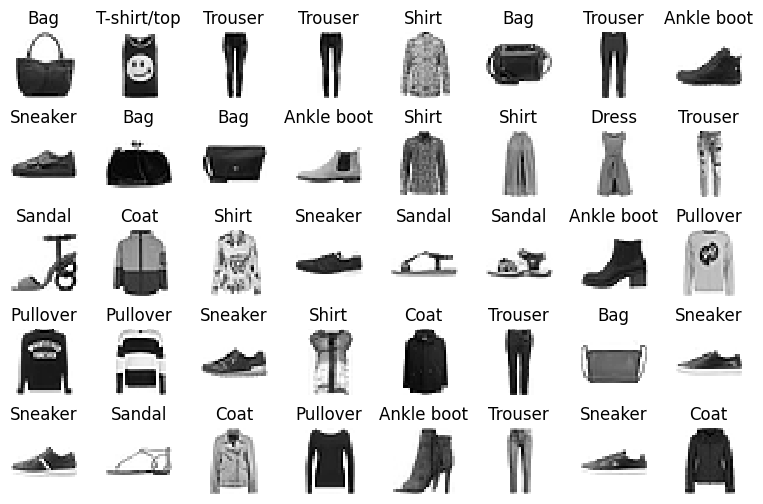

 0: T-shirt/top
 1: Trouser
 2: Pullover
 3: Dress
 4: Coat
 5: Sandal
 6: Shirt
 7: Sneaker
 8: Bag
 9: Ankle boot


(55000, 28, 28)

(55000,)

(5000, 28, 28)

(5000,)

(10000, 28, 28)

(10000,)

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
len(fashion_mnist)
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

imgW = X_train_full[0].shape[1]
imgH = X_train_full[0].shape[0]
print(f"Size of images = W: {imgW} pixels x H: {imgH} pixels = {imgW*imgH} pixels")

fashion_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
nclass = len(fashion_names)

X_train_full = X_train_full/255.0
X_test = X_test/255.0

t4pPC.centerTitle("Sample of the fashion items")
plotFashionToGrid(X_train_full, y_train_full, fashion_names, nrows=5, ncols=8, startFrom=100, IMAGES_PATH="./ML-Figures/FashionMNIST/IMGS/", save_imgs=True)

t4pPC.centerTitle("Fashion names")
for i, f in enumerate(fashion_names):
    print(f"{i:2d}: {f}")

X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
t4pPC.centerTitle("Training set")
X_train.shape
y_train.shape
t4pPC.centerTitle("Validation set")
X_valid.shape
y_valid.shape
t4pPC.centerTitle("Test set")
X_test.shape
y_test.shape



### Stacked autoencoders

<div id="CompilationOfTheModel"></div>

#### Creation and compilation of the model

/home/romuald/Python3/ML/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │        81,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,530 (318.48 KB)

 Trainable params: 81,530 (318.48 KB)

 Non-trainable params: 0 (0.00 B)

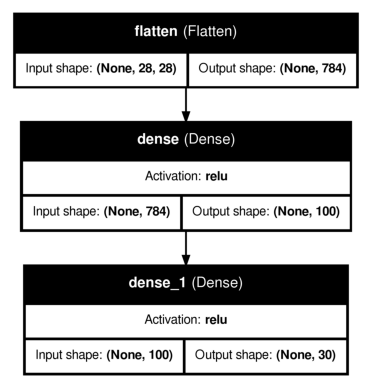

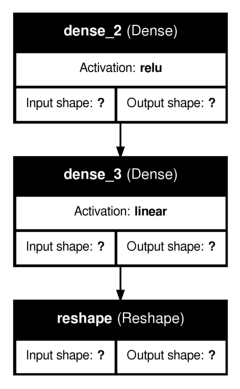

In [5]:
tf.keras.backend.clear_session()

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[imgH,imgW]),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(imgW * imgH),
    tf.keras.layers.Reshape([imgH, imgW])
])
stacked_aeModel = tf.keras.Sequential([stacked_encoder, stacked_decoder])

t4pPC.centerTitle("Summary of the model")
stacked_encoder.build()
stacked_decoder.build()
stacked_aeModel.build()
stacked_aeModel.summary()

t4pPC.centerTitle("Plot models")
plotModel(stacked_encoder, "StackedEncoder", MODELS_PATH=MODELS_PATH)
print()
plotModel(stacked_decoder, "StackedDecoder", MODELS_PATH=MODELS_PATH)


In [6]:
stacked_aeModel.compile(loss="mse", optimizer="nadam")

#### Training

In [7]:
history_ae = stacked_aeModel.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0339 - val_loss: 0.0176
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0170 - val_loss: 0.0162
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0158 - val_loss: 0.0155
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0151 - val_loss: 0.0150
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0147 - val_loss: 0.0146
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0141 - val_loss: 0.0142
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 9/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0137 - val_loss: 0.0139
Epoch 10/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0136 - val_loss: 0.0138
Epoch 11/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0135 - val_loss: 0.0137
Epoch 12/20
1719/1719 ━━━━━━━━

#### Save the models

In [8]:
from varname import nameof
file = MODELS_PATH / f"{nameof(stacked_aeModel)}.keras"
stacked_aeModel.save(file)

file = MODELS_PATH / f"{nameof(stacked_encoder)}.keras"
stacked_encoder.save(file)

file = MODELS_PATH / f"{nameof(stacked_decoder)}.keras"
stacked_decoder.save(file)

#### Jump to this section if you do not want to train the models again

<div class="rqT" title="warning">

Don't forget to <a href="#CompilationOfTheModel">first create and compile the models (autoencoder, but also encoder and decoder)</a>
</div>

In [9]:
from varname import nameof
file = MODELS_PATH / f"{nameof(stacked_aeModel)}.keras"
stacked_aeModel = keras.models.load_model(file)

file = MODELS_PATH / f"{nameof(stacked_encoder)}.keras"
stacked_encoder = keras.models.load_model(file)

file = MODELS_PATH / f"{nameof(stacked_decoder)}.keras"
stacked_decoder = keras.models.load_model(file)

#### Visualizing the Reconstructions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


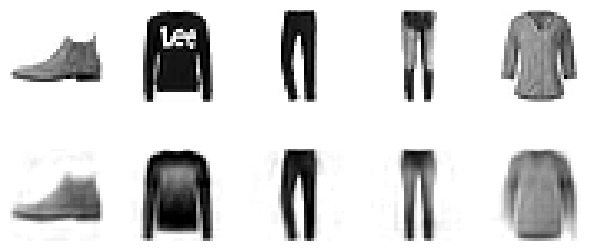

In [10]:
compareReconstructionsWithOriginalImages(stacked_aeModel,X_test)


<div class="rq">

Reconstructed images look blurry, but don't forget that original images were compressed down to 30 numbers instead of 28 $\times$ 28 = 784
</div>

#### Playing in the latent space

##### Compression/Uncompression of one image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(1, 28, 28)


<Figure size 2400x200 with 0 Axes>

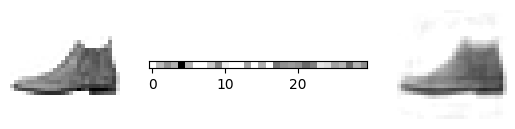

In [11]:
lsr, rimg = ShowLatentSpaceRepresentation(stacked_encoder,stacked_decoder, stacked_aeModel, X_test,0)

##### Normalize the latent space info

[[0.         0.80828613 1.3326969  0.9308557  3.030133   0.8853756
  0.         0.         0.6433606  1.511622   0.22913647 0.
  0.         1.0974281  0.         0.9401371  0.         1.6530573
  1.3096246  1.1903663  1.3186265  1.7907765  1.505863   0.31712565
  0.41583312 1.0886607  0.8744097  1.8104076  0.9193421  1.3561217 ]]


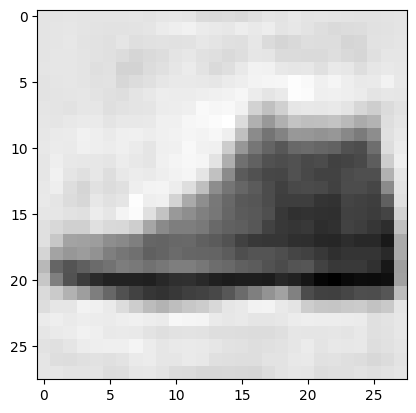

(<matplotlib.image.AxesImage at 0x7f21c5e7bf50>, None)

[[0.         0.26674938 0.43981466 0.30719963 1.         0.29219034
  0.         0.         0.21232091 0.49886322 0.07561928 0.
  0.         0.3621716  0.         0.31026265 0.         0.54553956
  0.43220034 0.39284292 0.43517116 0.5909894  0.49696267 0.10465734
  0.13723263 0.3592782  0.2885714  0.597468   0.30339992 0.44754526]]
(1, 30)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


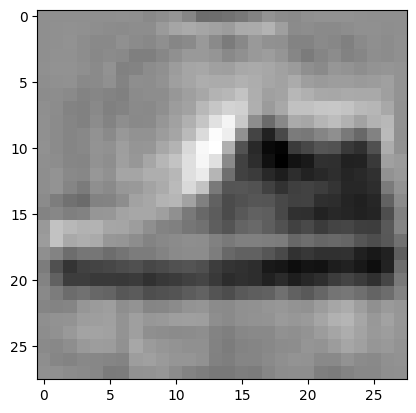

(<matplotlib.image.AxesImage at 0x7f21c5f13690>, None)

In [12]:
print(lsr)
plt.imshow(rimg.reshape(28,28), cmap=plt.cm.binary, interpolation="nearest"), plt.show()
lsrN = (lsr - lsr.min()) / (lsr.max()- lsr.min())
print(lsrN)
print(lsrN.shape)
rimgN = stacked_decoder.predict(lsrN)
plt.imshow(rimgN.reshape(28,28), cmap=plt.cm.binary, interpolation="nearest"), plt.show()

##### Make a random latent space code

30
[[1.2788536  0.05002151 0.55005864 0.44642148 1.47294243 1.35339897
  1.78435914 0.17387767 0.84384364 0.05959444 0.43727595 1.01071058
  0.05307194 0.3976753  1.29976888 1.08988296 0.44088124 1.17853137
  1.61886091 0.01299752 1.6116385  1.39627879 0.68050103 0.310959
  1.91442614 0.67318909 0.18549169 0.19343275 1.69498873 1.20745206]]
(1, 30)


([], [])

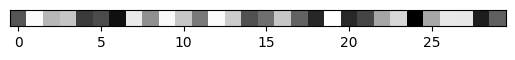

In [13]:
import random
import numpy as np
random.seed(42)
rndlsr = [random.uniform(0.,2.) for i in range(30)]
print(len(rndlsr))
rndlsr=np.array(rndlsr)
rndlsr = rndlsr.reshape((1,-1))
print(rndlsr)
print(rndlsr.shape)
plt.imshow(rndlsr, cmap=plt.cm.binary, interpolation="nearest")
plt.yticks([])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


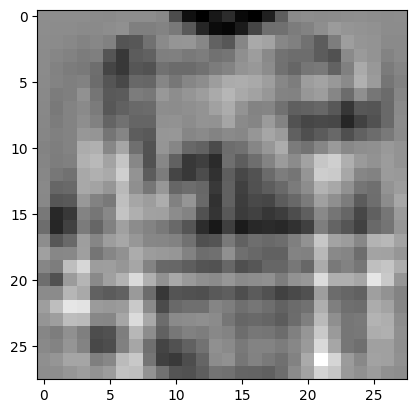

In [14]:
rndrimg = stacked_decoder.predict(rndlsr)
plt.imshow(rndrimg.reshape(28,28), cmap=plt.cm.binary, interpolation="nearest")
plt.show()

##### Switch on each neuron of the latent space

<Figure size 1574.8x649.606 with 0 Axes>

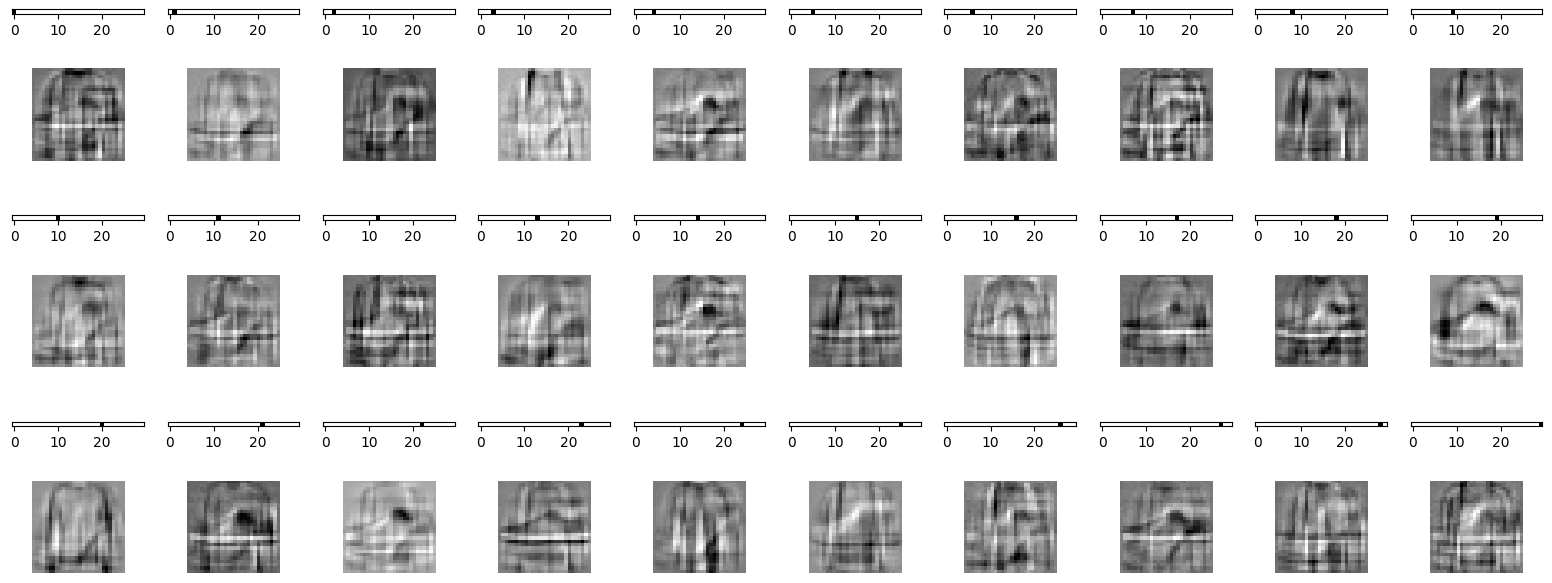

In [15]:
cm = 1/2.54
ncols = 10
nrows = 3
plt.figure(figsize=(ncols*4*cm, nrows*5.5*cm))
indexLSR = 0
indexIMG = 0
index = 0
for row in range(nrows):
    for col in range(ncols):
        index += 1
        indexLSR = (row)*2*ncols + col + 1
        indexIMG = indexLSR + ncols
        lsrPixByPix = np.zeros_like(rndlsr)
        lsrPixByPix[0,index-1] = 1.0
        imgPixByPix = stacked_decoder.predict(lsrPixByPix,verbose=0)
        _ = plt.subplot(nrows*2, ncols, indexLSR)
        _ = plt.imshow(lsrPixByPix, cmap=plt.cm.binary, interpolation="nearest")
        _ = plt.yticks([])
        _ = plt.subplot(nrows*2, ncols, indexIMG)
        _ = plt.imshow(imgPixByPix.reshape(28,28), cmap=plt.cm.binary, interpolation="nearest")
        _ = plt.axis("off")
plt.tight_layout()
plt.show()


##### Encode/Decode free-hand drawings

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
(1, 28, 28)


<Figure size 2400x200 with 0 Axes>

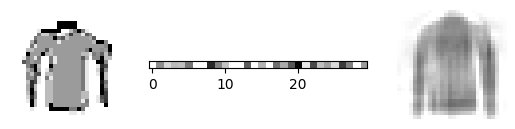

In [16]:
fh_img = plt.imread("./ML-Figures/FashionMNIST/FreehandDrawing_Shirt_28x28.png")
fh_img = fh_img.reshape(1,fh_img.shape[0],fh_img.shape[1]); plt.show()
lsr, rimg = ShowLatentSpaceRepresentation(stacked_encoder,stacked_decoder, stacked_aeModel, fh_img,0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
(1, 28, 28)


<Figure size 2400x200 with 0 Axes>

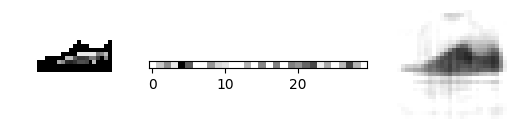

In [17]:
fh_img = plt.imread("./ML-Figures/FashionMNIST/FreehandDrawing_Sneaker_28x28.png")
fh_img = fh_img.reshape(1,fh_img.shape[0],fh_img.shape[1]); plt.show()
lsr, rimg = ShowLatentSpaceRepresentation(stacked_encoder,stacked_decoder, stacked_aeModel, fh_img,0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
(1, 28, 28)


<Figure size 2400x200 with 0 Axes>

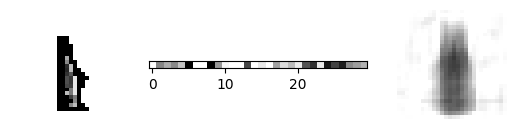

In [18]:
fh_img = plt.imread("./ML-Figures/FashionMNIST/FreehandDrawing_SneakerVertical_28x28.png")
fh_img = fh_img.reshape(1,fh_img.shape[0],fh_img.shape[1]); plt.show()
lsr, rimg = ShowLatentSpaceRepresentation(stacked_encoder,stacked_decoder, stacked_aeModel, fh_img,0)

##### Reconstruct an image with defects?

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
(1, 28, 28)


<Figure size 2400x200 with 0 Axes>

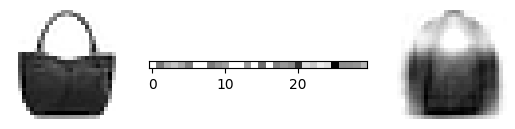

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
(1, 28, 28)


<Figure size 2400x200 with 0 Axes>

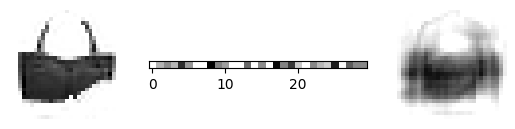

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
(1, 28, 28)


<Figure size 2400x200 with 0 Axes>

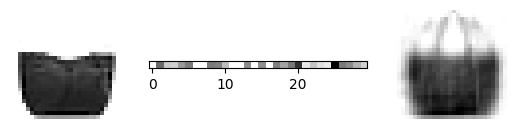

In [19]:
t4pPC.centerTitle('Original image')
fh_img = plt.imread("./ML-Figures/FashionMNIST/img000100.png")
fh_img = fh_img.reshape(1,fh_img.shape[0],fh_img.shape[1]); plt.show()
lsr, rimg = ShowLatentSpaceRepresentation(stacked_encoder,stacked_decoder, stacked_aeModel, fh_img,0)

t4pPC.centerTitle('Image with defect. 1')
fh_img = plt.imread("./ML-Figures/FashionMNIST/img000100Defect1.png")
fh_img = fh_img.reshape(1,fh_img.shape[0],fh_img.shape[1]); plt.show()
lsr, rimg = ShowLatentSpaceRepresentation(stacked_encoder,stacked_decoder, stacked_aeModel, fh_img,0)

t4pPC.centerTitle('Image with defect. 2')
fh_img = plt.imread("./ML-Figures/FashionMNIST/img000100Defect2.png")
fh_img = fh_img.reshape(1,fh_img.shape[0],fh_img.shape[1]); plt.show()
lsr, rimg = ShowLatentSpaceRepresentation(stacked_encoder,stacked_decoder, stacked_aeModel, fh_img,0)


#### Visualization of the latent space

In [20]:
from sklearn.manifold import TSNE
X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)
print(X_valid_2D)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[ 56.338768     0.78898287]
 [ 22.953236   -48.50835   ]
 [ 39.132816    18.467846  ]
 ...
 [ 17.397955    56.55383   ]
 [  6.3423395   11.55591   ]
 [-42.567524     3.900533  ]]


0 T-shirt/top (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)
1 Trouser (1.0, 0.4980392156862745, 0.054901960784313725, 1.0)
2 Pullover (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)
3 Dress (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)
4 Coat (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0)
5 Sandal (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)
6 Shirt (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0)
7 Sneaker (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0)
8 Bag (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0)
9 Ankle boot (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)


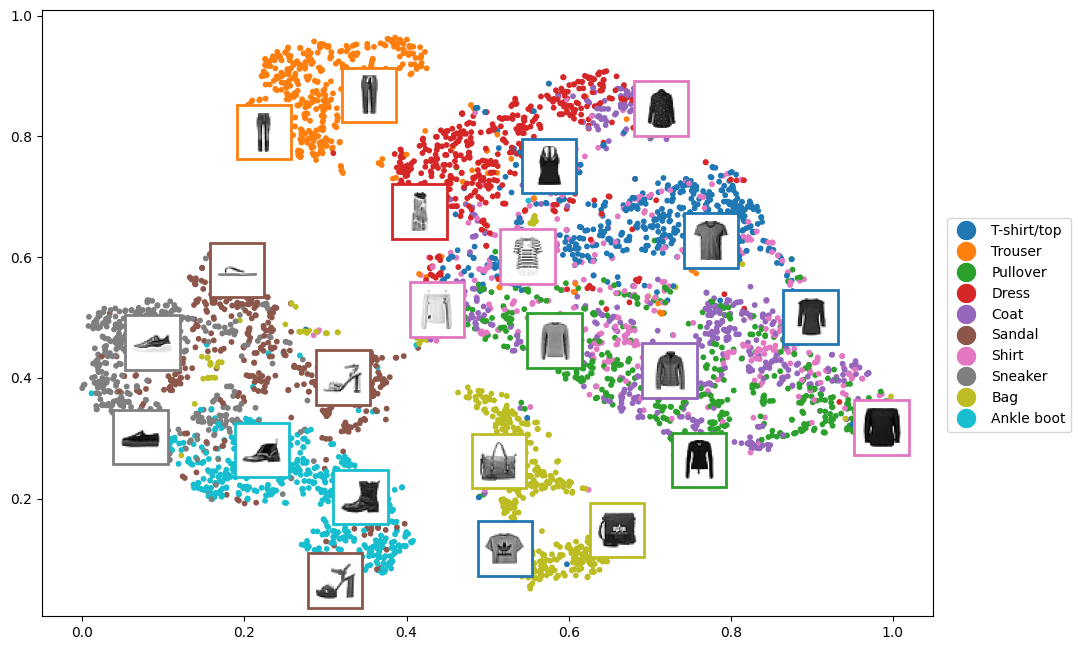

In [21]:
import matplotlib as mpl
from matplotlib.lines import Line2D
cmap = plt.cm.tab10
t4pPC.centerTitle('Fashion indexes, names and colors in the selected color map scheme')
LegendElements = []
for i, f in enumerate(fashion_names):
    print(i, f, cmap(i))
    LegendElement = Line2D([0], [0], marker='o', color='w', label=f, markerfacecolor=cmap(i), markersize=15)
    LegendElements.append(LegendElement)

t4pPC.centerTitle('TSNE scheme')
Z = X_valid_2D.copy()
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
cm = 1/2.54
fig, ax = plt.subplots(figsize=(30*cm, 20*cm))
scatter = ax.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap="tab10")
fig.legend(handles=LegendElements, loc='center right',fontsize=10)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        _ = ax.add_artist(imagebox)
        
fig.subplots_adjust(right=0.88)
plt.show()

# Useful links

[Autoencoder article on Wikipedia](https://en.wikipedia.org/wiki/Autoencoder)

[Hands-on machine learning with scikit-learn, keras and tensorflow (3rd edition, **2022**), Aurélien Géron, O'Reilly editions](https://github.com/ageron/handson-ml3)

Some images were generated with [DALL·E](https://openai.com/dall-e-2)

In [25]:
vID.end(cwd0)

**End at:** Wednesday 27 March 2024, 12:11:56  
**Duration:** 00:04:11 032ms

<p style="text-align: center"><img width="800px" src="./config/svg/logoEnd.svg" style="margin-left:auto; margin-right:auto"/></p>